In [16]:
from vllm import LLM, SamplingParams
import pandas as pd
from tqdm import tqdm
import json
import matplotlib

In [35]:
instruction = '\n\nConsider the following MCQ Questions. response with the letter:\n\n'

def getOptionsString(options):
    res = ''
    for i in options:
        res += i + ': ' + options[i]
        res += '\n'
    return res

def getLetter(llm_response):
    for i in llm_response.split('\n'):
        if(len(i) > 1 and i[0] != '#'):
            return i[0]

In [36]:
# data = pd.read_json(path_or_buf='/home/tgao/Github/llm/data_clean/questions/US/US_qbank.jsonl', lines=True)
data = pd.read_csv('/home/tgao/Github/llm/llama_out.csv')
data

,question,answer,options,meta_info,model_letter,model_response
0,A 4670-g (10-lb 5-oz) male newborn is delivere...,D,"{'A': 'Nerve conduction study', 'B': 'Surgical...",step2,E,E Splinting of the arm. The explanation is as...
1,A 66-year-old man comes to the physician for a...,F,"{'A': 'Cirrhosis', 'B': 'Acute lymphoblastic l...",step2,F,F Acute myelogenous leukemia. The patient's s...
2,A 40-year-old man comes to the physician becau...,E,"{'A': 'Asphyxia', 'B': 'Achlorhydria', 'C': 'T...",step2,D,D Megaloblastic anemia. \n\nExplanation: \n\n...
3,A 4-year-old boy is brought to the emergency d...,E,"{'A': ""Get consent from the patient's brother""...",step2,E,E. Perform emergency laparotomy.\n\nExplanati...
4,A 9-year-old girl is brought to the emergency ...,C,"{'A': 'Oculomotor nerve damage', 'B': 'Retrobu...",step2,F,F Abducens nerve damage. The patient's sympto...
...,...,...,...,...,...,...
14364,A 9-year-old boy is brought to the clinic by h...,A,"{'A': 'Defect of the septum secundum', 'B': 'F...",step1,B,B Failure of the septum primum to fuse with t...
14365,A 3-month-old infant is brought to the E.R. by...,B,"{'A': 'Recent pharyngitis', 'B': 'Recent consu...",step1,B,B Recent consumption of honey. The reason for...
14366,A 36-year-old woman with no significant medica...,A,"{'A': 'Formation of free radicals', 'B': 'Inhi...",step1,D,D Binding to the 50S subunit of the ribosome....
14367,A 68-year-old male is brought to his primary c...,A,"{'A': 'Accumulations of beta-pleated sheets', ...",step1,D,D Intracellular rounded hyperphosphorylated t...


<Axes: xlabel='model_letter'>

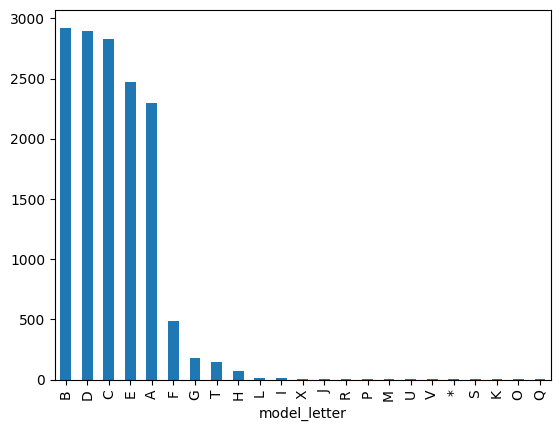

In [42]:
# data.hist(list(data['model_letter']))
data.model_letter.value_counts().plot(kind='bar')


In [43]:
data['options'][3]

'{\'A\': "Get consent from the patient\'s brother", \'B\': \'Get consent from the patient\', \'C\': \'Obtain a court order for surgery\', \'D\': \'Schedule hospital ethics consult\', \'E\': \'Perform emergency laparotomy\', \'F\': \'Delay surgery until parental consent\'}'

In [44]:
data['model_response'][3]

' E. Perform emergency laparotomy.\n\nExplanation: In this scenario, the patient'

In [45]:
n_correct = 0
n = len(data)

for i in range(len(data)):
    if data['model_letter'][i] == data['answer'][i]:
        n_correct += 1
        


In [46]:
print(n_correct / n)

0.6379010369545549


In [47]:
tot_prob = 0
for i in range(len(data)):
    tot_prob += 1 / data['options'][i].count(':')

print('Avg: ', tot_prob / len(data))

Avg:  0.1887639089747582


In [1]:
from vllm import LLM, SamplingParams
import pandas as pd
from llm_functions import query_llm
from tqdm import tqdm
import random

llm = LLM(model="meta-llama/Meta-Llama-3-8B-Instruct")

data = pd.read_csv('/home/tgao/Github/llm/llama_out.csv')

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def get_all_edits(word, n=1):
    if n == 1:
        return edits1(word)
    
    last = get_all_edits(word, n-1)

    res = set()
    for i in last:
        cur = edits1(i)
        for j in cur:
            res.add(j)
    return res
    

INFO 06-08 01:45:18 llm_engine.py:161] Initializing an LLM engine (v0.4.3) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B-Instruct)


/home/tgao/.conda/envs/llm/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 06-08 01:45:21 weight_utils.py:207] Using model weights format ['*.safetensors']
INFO 06-08 01:45:24 model_runner.py:146] Loading model weights took 14.9595 GB
INFO 06-08 01:45:25 gpu_executor.py:83] # GPU blocks: 27894, # CPU blocks: 2048
INFO 06-08 01:45:26 model_runner.py:854] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-08 01:45:26 model_runner.py:858] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-08 01:45:30 model_runner.py:924] Graph capturing finished in 4 secs.


In [6]:
from vllm import LLM, SamplingParams

sampling_params = SamplingParams(temperature=0)

def query_llm(llm, prompts, verbose=False):
    outputs = llm.generate(prompts, sampling_params, use_tqdm=verbose)
    
    return [output.outputs[0].text for output in outputs]

def getOptionsString(options):
    res = ''
    for i in options:
        res += i + ' ' + options[i]
        res += '\n'
    return res

def getLetter(llm_response):
    # for i in llm_response.split('\n'):
    #     if(len(i) > 1 and i[0] != '#'):
    #         return i[0]
    
    for i in llm_response:
        if i.isupper():
            return i
    return '*'

In [24]:
def select_random_subset(f, subset_size=1000):
    """
    Select a random subset of specified size from the list f.

    Parameters:
    f (list): The list to select from.
    subset_size (int): The size of the subset to select.

    Returns:
    list: A random subset of the original list.
    """
    if subset_size > len(f):
        raise ValueError("Subset size is larger than the size of the input list")
    
    return random.sample(f, subset_size)

In [18]:
temp = pd.read_json(path_or_buf='/home/tgao/Github/llm/data_clean/questions/US/US_qbank.jsonl', lines=True)

In [40]:
llm = LLM(model="meta-llama/Meta-Llama-3-8B-Instruct")

n_samples = 10
idx = 0

res = []

bads = 0

while idx < n_samples:
    i = random.choice(range(len(data)))
    
    if(data['answer'][i] == data['model_letter'][i]):
        continue

    original_q = data['question'][i]
    options_str = getOptionsString(temp['options'][i])
    
    found = False
    
    all_qs = []
    for j in get_all_edits(original_q, 1):
        
        query = 'Question -\n\n' + j + '\nChoices -\n' + options_str
        query += '\nAs an extremely experienced and knowledgable medical professional answering this question accurately, the letter of the correct answer is '
        
        all_qs.append(query)
    
    if len(all_qs) > 1000:
        all_qs = select_random_subset(all_qs, 1000)
    
    print(len(all_qs))
    
    llm_ans = query_llm(llm, all_qs, verbose=True)
        
    # for i in llm_ans:
    #     if(getLetter(i) != data['answer'][i]):
    #         print(i, data['answer'][i])
    #         print('=' * 30)
            
    #         res.append((i, data['answer'][i]))
            
    #         found = True
    #         break
        
    # bads += 1

INFO 06-08 02:02:47 llm_engine.py:161] Initializing an LLM engine (v0.4.3) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B-Instruct)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 